In [1]:
import imutils
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np

# USER-SET PARAMETERS

In [9]:
# Number of frames to pass before changing the frame to compare the current
# frame against
FRAMES_TO_PERSIST = 10

# Minimum boxed area for a detected motion to count as actual motion
# Use to filter out noise or small objects
MIN_SIZE_FOR_MOVEMENT = 2000

# Minimum length of time where no motion is detected it should take
#(in program cycles) for the program to declare that there is no movement
MOVEMENT_DETECTED_PERSISTENCE = 100

In [10]:
# Create capture object
cap = cv2.VideoCapture(5) # Flush the stream
cap.release()
cap = cv2.VideoCapture(1) # Then start the webcam

In [11]:
img_1 = cv2.imread("image/1.jpg")
img_2 = cv2.imread("image/2.jpg")
img_3 = cv2.imread("image/3.jpg")
img_4 = cv2.imread("image/4.jpg")
img_5 = cv2.imread("image/5.jpg")
img_6 = cv2.imread("image/6.jpg")

In [12]:
def plot_img(img1, img2, img3, img4 = None):
    fig = plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')

    fig.add_subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

    fig.add_subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.show()

    plt.figure(num=None, figsize=(6, 6), dpi=100, facecolor='w', edgecolor='k')
    plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
    plt.show()

    if img4 is not None:
        plt.figure(num=None, figsize=(6, 6), dpi=100, facecolor='w', edgecolor='k')
        plt.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
    plt.show()

In [45]:
def img_diff(input_1, input_2):
    # Resize and save a greyscale version of the image
    frame_1 = cv2.resize(input_1, (500, 500), interpolation=cv2.INTER_CUBIC)
    gray_1 = cv2.cvtColor(frame_1, cv2.COLOR_BGR2GRAY)
    frame_2 = cv2.resize(input_2, (500, 500), interpolation=cv2.INTER_CUBIC)
    gray_2 = cv2.cvtColor(frame_2, cv2.COLOR_BGR2GRAY)

    # Blur it to remove camera noise (reducing false positives)
    gray_1 = cv2.GaussianBlur(gray_1, (41, 41), 0)
    gray_2 = cv2.GaussianBlur(gray_2, (41, 41), 0)

    # Compare the two frames, find the difference
    frame_delta = cv2.absdiff(gray_1, gray_2)
    thresh = cv2.threshold(frame_delta, 25, 255, cv2.THRESH_BINARY)[1]

    # Fill in holes via dilate(), and find contours of the thesholds
    thresh = cv2.dilate(thresh, None, iterations = 2)
    # Convert the frame_delta to color for splicing
    #frame_delta = cv2.threshold(frame_delta, 25, 255, cv2.THRESH_BINARY)[1]
    frame_delta = cv2.cvtColor(frame_delta, cv2.COLOR_GRAY2BGR)
    #frame_delta[..., 0] = 0
    frame_delta[..., 1] = 0
    return frame_2, frame_delta

In [46]:
def draw_flow(img, flow, step=8):
    
    #from the beginning to position 2 (excluded channel info at position 3)
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

def draw_hsv(flow):
    (h, w) = flow.shape[:2]
    (fx, fy) = (flow[:, :, 0], flow[:, :, 1])
    ang = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx * fx + fy * fy)
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[..., 0] = ang * (180 / np.pi / 2)
    hsv[..., 1] = 0xFF
    hsv[..., 2] = np.minimum(v * 4, 0xFF)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

def optical_flow(input_1, input_2):
    # Resize and save a greyscale version of the image
    frame_1 = cv2.resize(input_1, (300, 300), interpolation=cv2.INTER_CUBIC)
    gray_1 = cv2.cvtColor(frame_1, cv2.COLOR_BGR2GRAY)
    frame_2 = cv2.resize(input_2, (300, 300), interpolation=cv2.INTER_CUBIC)
    gray_2 = cv2.cvtColor(frame_2, cv2.COLOR_BGR2GRAY)
    
    gray_1 = cv2.GaussianBlur(gray_1, (21, 21), 0)
    gray_2 = cv2.GaussianBlur(gray_2, (21, 21), 0)

    flow = cv2.calcOpticalFlowFarneback(gray_1, gray_2, None,0.5,5,15,3,5,1.1,cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

    flow_img = draw_flow(gray_1, flow)
    map_img = draw_hsv(flow)
    
    return flow_img, map_img

In [49]:
start_t = time.time()
now_t = time.time()
prev_step_t = time.time()
pre_frame = None
next_frame = None
while now_t - start_t < 20:
    now_t = time.time()
    if now_t - prev_step_t < 1/18.:
        continue
    
    prev_step_t = now_t
    
    ret, next_frame = cap.read()
    if pre_frame is not None:
        
        input_img, map_img = optical_flow(pre_frame, next_frame)
        #input_img, map_img = img_diff(pre_frame, next_frame)
        
        overlapping = cv2.addWeighted(input_img, 0.5, map_img, 0.5, 0)
        
        #cv2.imshow("frame", np.hstack((next_frame, overlapping)))
        cv2.imshow("frame", overlapping)
    
    else:
        avg = next_frame
    
    
    ch = cv2.waitKey(1)
    if ch & 0xFF == ord('q'):
        break    
    pre_frame = next_frame
    
cv2.waitKey(0)
cv2.destroyAllWindows()

('Time: ', 0.026035070419311523)


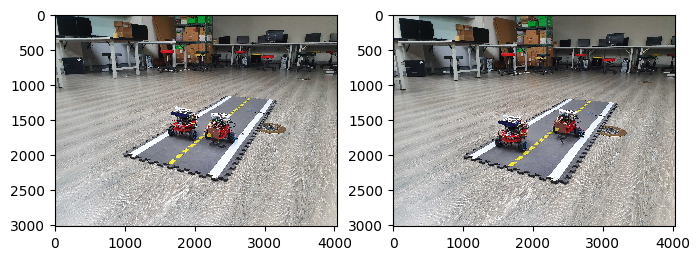

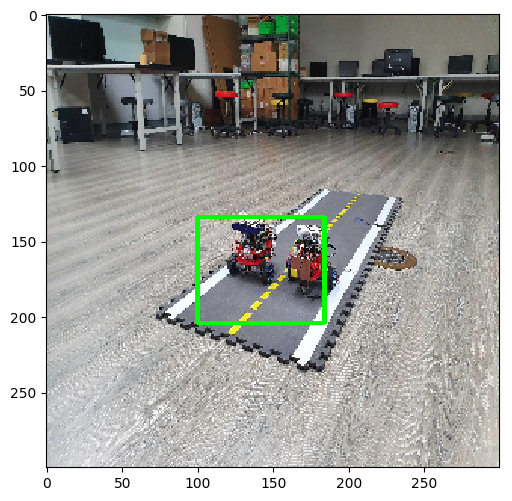

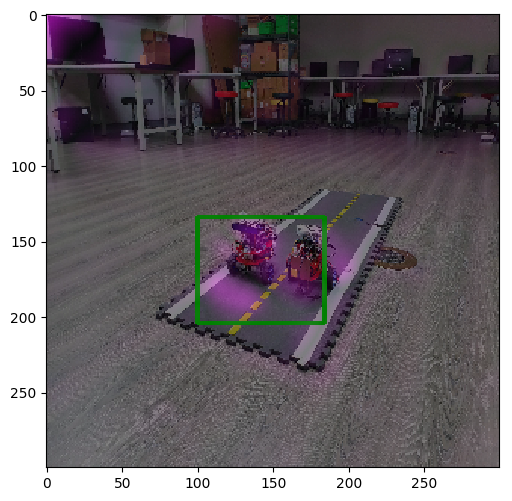

In [13]:
# Set transient motion detected as false
transient_movement_flag = False

input_1, input_2 = img_2.copy(), img_6.copy()

start_t = time.time()
# Resize and save a greyscale version of the image
frame_1 = cv2.resize(input_1, (300, 300), interpolation=cv2.INTER_CUBIC)
gray_1 = cv2.cvtColor(frame_1, cv2.COLOR_BGR2GRAY)
frame_2 = cv2.resize(input_2, (300, 300), interpolation=cv2.INTER_CUBIC)
gray_2 = cv2.cvtColor(frame_2, cv2.COLOR_BGR2GRAY)

# Blur it to remove camera noise (reducing false positives)
gray_1 = cv2.GaussianBlur(gray_1, (41, 41), 0)
gray_2 = cv2.GaussianBlur(gray_2, (41, 41), 0)

# Compare the two frames, find the difference
frame_delta = cv2.absdiff(gray_1, gray_2)
thresh = cv2.threshold(frame_delta, 25, 255, cv2.THRESH_BINARY)[1]

# Fill in holes via dilate(), and find contours of the thesholds
thresh = cv2.dilate(thresh, None, iterations = 2)
cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# loop over the contours
for c in cnts:

    # Save the coordinates of all found contours
    (x, y, w, h) = cv2.boundingRect(c)

    # If the contour is too small, ignore it, otherwise, there's transient
    # movement
    if cv2.contourArea(c) > MIN_SIZE_FOR_MOVEMENT:
        transient_movement_flag = True

        # Draw a rectangle around big enough movements
        cv2.rectangle(frame_1, (x, y), (x + w, y + h), (0, 255, 0), 2)
        #print("Move")

# Convert the frame_delta to color for splicing
#frame_delta = cv2.threshold(frame_delta, 25, 255, cv2.THRESH_BINARY)[1]
frame_delta = cv2.cvtColor(frame_delta, cv2.COLOR_GRAY2BGR)
#frame_delta[..., 0] = 0
frame_delta[..., 1] = 0

print("Time: ", time.time()-start_t)

overlapping = cv2.addWeighted(frame_1, 0.5, frame_delta, 1, 0)

plot_img(input_1, input_2, frame_1, overlapping)

('Time: ', 0.045755863189697266)


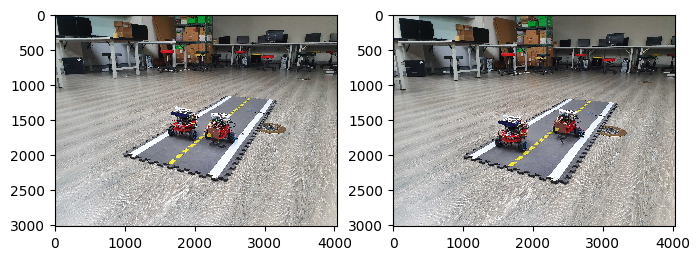

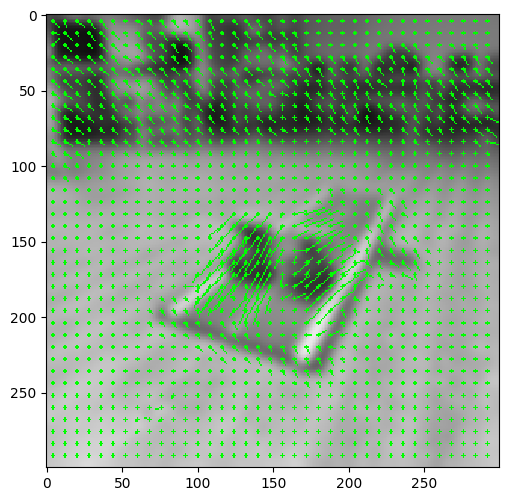

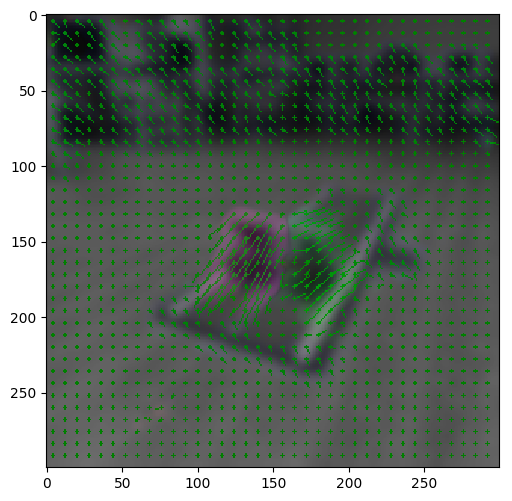

In [106]:
input_1, input_2 = img_2.copy(), img_6.copy()

start_t = time.time()
# Resize and save a greyscale version of the image
frame_1 = cv2.resize(input_1, (300, 300), interpolation=cv2.INTER_CUBIC)
gray_1 = cv2.cvtColor(frame_1, cv2.COLOR_BGR2GRAY)
frame_2 = cv2.resize(input_2, (300, 300), interpolation=cv2.INTER_CUBIC)
gray_2 = cv2.cvtColor(frame_2, cv2.COLOR_BGR2GRAY)

gray_1 = cv2.GaussianBlur(gray_1, (21, 21), 0)
gray_2 = cv2.GaussianBlur(gray_2, (21, 21), 0)

flow = cv2.calcOpticalFlowFarneback(gray_1, gray_2, None,0.5,5,15,3,5,1.1,cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

flow_img = draw_flow(gray_1, flow)

overlapping = cv2.addWeighted(flow_img, 0.5, draw_hsv(flow), 0.5, 0)

print("Time: ", time.time() - start_t)

plot_img(input_1, input_2, flow_img, overlapping)

# CORE PROGRAM

In [6]:
# Create capture object
cap = cv2.VideoCapture(5) # Flush the stream
cap.release()
cap = cv2.VideoCapture(1) # Then start the webcam

# Init frame variables
first_frame = None
next_frame = None

# Init display font and timeout counters
font = cv2.FONT_HERSHEY_SIMPLEX
delay_counter = 0
movement_persistent_counter = 0

In [7]:
# LOOP!
while True:

    # Set transient motion detected as false
    transient_movement_flag = False
    
    # Read frame
    ret, frame = cap.read()
    text = "Unoccupied"

    # If there's an error in capturing
    if not ret:
        print("CAPTURE ERROR")
        continue

    # Resize and save a greyscale version of the image
    #frame = imutils.resize(frame, width = 750)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Blur it to remove camera noise (reducing false positives)
    gray = cv2.GaussianBlur(gray, (21, 21), 0)

    # If the first frame is nothing, initialise it
    if first_frame is None: first_frame = gray    

    delay_counter += 1

    # Otherwise, set the first frame to compare as the previous frame
    # But only if the counter reaches the appriopriate value
    # The delay is to allow relatively slow motions to be counted as large
    # motions if they're spread out far enough
    if delay_counter > FRAMES_TO_PERSIST:
        delay_counter = 0
        first_frame = next_frame

        
    # Set the next frame to compare (the current frame)
    next_frame = gray

    # Compare the two frames, find the difference
    frame_delta = cv2.absdiff(first_frame, next_frame)
    thresh = cv2.threshold(frame_delta, 25, 255, cv2.THRESH_BINARY)[1]

    # Fill in holes via dilate(), and find contours of the thesholds
    thresh = cv2.dilate(thresh, None, iterations = 2)
    cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # loop over the contours
    for c in cnts:

        # Save the coordinates of all found contours
        (x, y, w, h) = cv2.boundingRect(c)
        
        # If the contour is too small, ignore it, otherwise, there's transient
        # movement
        if cv2.contourArea(c) > MIN_SIZE_FOR_MOVEMENT:
            transient_movement_flag = True
            
            # Draw a rectangle around big enough movements
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # The moment something moves momentarily, reset the persistent
    # movement timer.
    if transient_movement_flag == True:
        movement_persistent_flag = True
        movement_persistent_counter = MOVEMENT_DETECTED_PERSISTENCE

    # As long as there was a recent transient movement, say a movement
    # was detected    
    if movement_persistent_counter > 0:
        text = "Movement Detected " + str(movement_persistent_counter)
        movement_persistent_counter -= 1
    else:
        text = "No Movement Detected"

    # Print the text on the screen, and display the raw and processed video 
    # feeds
    cv2.putText(frame, str(text), (10,35), font, 0.75, (255,255,255), 2, cv2.LINE_AA)
    
    # For if you want to show the individual video frames
#    cv2.imshow("frame", frame)
#    cv2.imshow("delta", frame_delta)
    
    # Convert the frame_delta to color for splicing
    frame_delta = cv2.cvtColor(frame_delta, cv2.COLOR_GRAY2BGR)

    # Splice the two video frames together to make one long horizontal one
    cv2.imshow("frame", np.hstack((frame_delta, frame)))


    # Interrupt trigger by pressing q to quit the open CV program
    ch = cv2.waitKey(1)
    if ch & 0xFF == ord('q'):
        break

# Cleanup when closed
cv2.waitKey(0)
cv2.destroyAllWindows()
cap.release()

KeyboardInterrupt: 

In [5]:
ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255
while(1):
    ret, frame2 = cap.read()
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    cv2.imshow('frame2',bgr)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv2.imwrite('opticalfb.png',frame2)
        cv2.imwrite('opticalhsv.png',bgr)
    prvs = next

KeyboardInterrupt: 

In [4]:
def draw_flow(img, flow, step=16):
    
    #from the beginning to position 2 (excluded channel info at position 3)
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis


def draw_hsv(flow):
    (h, w) = flow.shape[:2]
    (fx, fy) = (flow[:, :, 0], flow[:, :, 1])
    ang = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx * fx + fy * fy)
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[..., 0] = ang * (180 / np.pi / 2)
    hsv[..., 1] = 0xFF
    hsv[..., 2] = np.minimum(v * 4, 0xFF)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    cv2.imshow('hsv', bgr)
    return bgr


def warp_flow(img, flow):
    (h, w) = flow.shape[:2]
    flow = -flow
    flow[:, :, 0] += np.arange(w)
    flow[:, :, 1] += np.arange(h)[:, np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return res

In [5]:
(ret, prev) = cap.read()

prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
show_hsv = False
show_glitch = False
cur_glitch = prev.copy()

while True:
    (ret, img) = cap.read()
    vis = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prevgray,gray,None,0.5,5,15,3,5,1.1,cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
    prevgray = gray
    cv2.imshow('flow', draw_flow(gray, flow))
    if show_hsv:
        gray1 = cv2.cvtColor(draw_hsv(flow), cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(gray1, 25, 0xFF,
                               cv2.THRESH_BINARY)[1]
        thresh = cv2.dilate(thresh, None, iterations=2)
        cv2.imshow('thresh', thresh)
        cnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # loop over the contours
        for c in cnts:

            # if the contour is too small, ignore it
            (x, y, w, h) = cv2.boundingRect(c)
            if w > 100 and h > 100 and w < 900 and h < 680:
                cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 0xFF, 0), 4)
                cv2.putText(vis,str(time.time()),(x, y),cv2.FONT_HERSHEY_SIMPLEX,1,(0, 0, 0xFF),1)
        cv2.imshow('Image', vis)
    if show_glitch:
        cur_glitch = warp_flow(cur_glitch, flow)
        cv2.imshow('glitch', cur_glitch)
    ch = 0xFF & cv2.waitKey(5)
cv2.destroyAllWindows()


KeyboardInterrupt: 